# Tarea semanal 4 bis²

## Filosofia de trabajo 

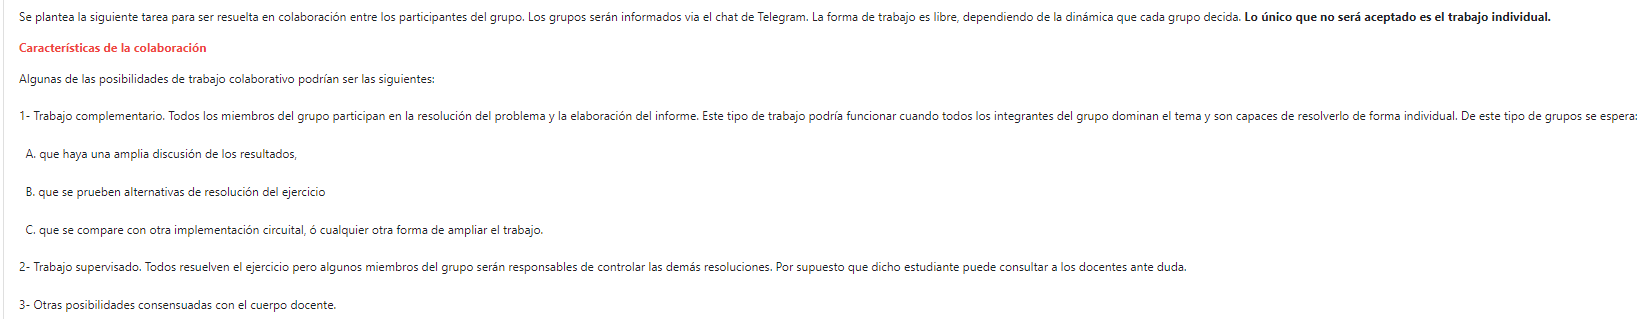

La caracteristica de colaboracion adoptada fue la de "trabajo supervisado", en la que los estudiantes resolvieron el ejercicio planteado en forma individual y corroboraron haber llegado a los mismo resultados.
A su vez se aplico una filosofia "colaborativa" a la hora de realizar la simulacion, ya que ambos integrantes participaron en esta tarea.

Tareas Realizadas por el alumno: Guido Glorioso
- Resolvió el ejercicio en forma escrita.
- Comprobó los resultados obtenidos con la simulacion numerica.
- Realizó las simulaciones numericas necesarias y las adjunto al documento.
- Realizó la simulacion circuital pasiva 
- Conclusiones generales

Tareas Realizadas por el alumno: Bruno Glecer

- Comprobacion de la resolucion escrita
- Revision y correcciones de la simulación.
- Revision y adición de detalles y explicaciones de los calculos con python de las transferencias.
- Calculo y simulacion de la version activada del filtro
- Conclusiones generales




<h2> Consignas </h2>

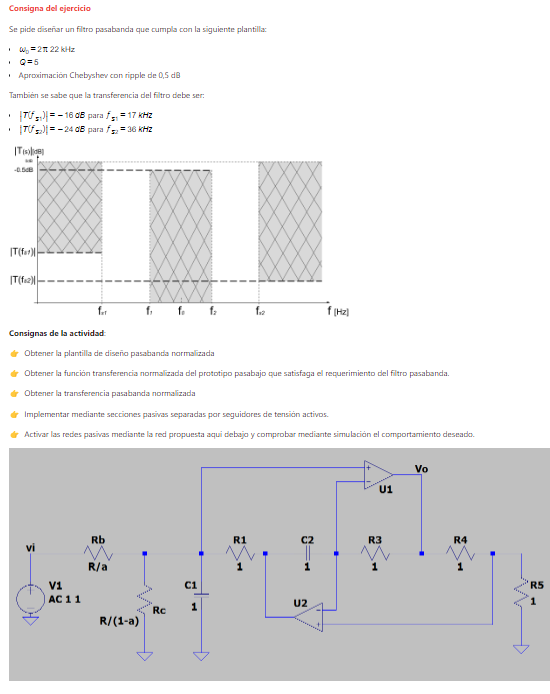

<h2> Resolucion de las consignas a mano</h2>

Se adjunta el desarrollo hecho a mano:

<object data="Desarrollo.pdf" type="application/pdf" width="100%" height="800px">
  <p>El archivo PDF no se puede mostrar. <a href="Desarrollo.pdf">Haz clic aquí para descargarlo.</a></p>
</object>


## Resolución con Python

### Parametros iniciales

In [1]:
import numpy as np
from scipy import signal as signal
from pytc2.sistemas_lineales import analyze_sys, pretty_print_bicuad_omegayq,tfcascade,pretty_print_lti

#parametros del filtro a diseñar
#fp1 y fp2 fueron calculados utilizando las relacion entre Q y ancho de banda.

fp1 = 19.90972 * 10**3
fp2 = 24.30952 * 10**3
fs1 = 17 * 10**3
fs2 = 36 * 10**3

### Parametros del filtro prototipo

In [2]:
#calculo norma de frecuencia y la aplico a los valores del filtro
norma_w = np.sqrt(fp1*fp2)

wp1_n = fp1 / norma_w 
wp2_n = fp2 / norma_w
ws1_n = fs1 / norma_w
ws2_n = fs2 / norma_w

print("Calculo de las frecuencias de corte normalizadas del filtro objetivo:")
print(f"Wp1_n={wp1_n};  Wp2_n={wp2_n}")
print(f"Ws1_n={ws1_n};  Ws2_n={ws2_n}")
print()

BW = wp2_n - wp1_n
Q = 1/BW

# valores de omega con nucleo de transformacion (para plantilla de pasa bajos)
omega_s1=  Q * (ws1_n**2 - 1)/ws1_n
omega_s2=  Q * (ws2_n**2 - 1)/ws2_n
omega_p1=  Q * (wp1_n**2 - 1)/wp1_n
omega_p2=  Q * (wp2_n**2 - 1)/wp2_n

# elijo los valores mas exigentes para el filtro (valor mas chico en modulo)

omega_s = np.abs( omega_s1)
omega_p = omega_p2

#obtengo los valores de epsilon y n del filtro pasabajos

alpha_max = 0.5
alpha_min = 16

epsilon = np.sqrt((10**(alpha_max/10)) - 1) 
print("Calculo del orden del filtro:")

for n in range(1,5): # veo que numero de N se necesita para la plantilla del PB
    alpha_min_c = 10 * np.log10(1+ epsilon**2 * np.cosh(n * np.arccosh(omega_s))**2 )
    print(f"alpha_min={alpha_min_c} para un n={n}")
    if alpha_min < alpha_min_c:
       alpha_min = alpha_min_c 
       n=3
       break
    n=0
print(f"Filtro de orden N={n} con un epsilon={epsilon}")

Calculo de las frecuencias de corte normalizadas del filtro objetivo:
Wp1_n=0.9049912586855338;  Wp2_n=1.1049830486235446
Ws1_n=0.7727306761548668;  Ws2_n=1.6363708436220707

Calculo del orden del filtro:
alpha_min=2.6228510302891723 para un n=1
alpha_min=13.085696819329051 para un n=2
alpha_min=26.86737148112998 para un n=3
Filtro de orden N=3 con un epsilon=0.34931140018894796


### Transferencia del filtro prototipo

Como fue encontrado arriba, el filtro prototipo será de 3er orden.

Para encontrar la transferencia del filtro prototipo, utilizamos el polinomio de 3er orden de Chebyshev: $C_3(x) = 4x^3 - 3x$

Entonces, la transferencia de potencia del filtro prototipo deseado es:

$$|T_{LP}(\Omega)|^2 = \dfrac{1}{1 + \varepsilon^2 (4\Omega^3 - 3\Omega)}$$

Expresado en terminos de la variable de frecuencia compleja del prototipo $p = \Sigma + j\Omega$

$$|T_{LP}(p)|^2 = - \dfrac{1}{16 \varepsilon^2} \dfrac{1}{p^6 + \frac{3}{2}p^4 + \frac{9}{16}p^2 - \frac{1}{16 \varepsilon^2}}$$

Continuamos identificando los polos de esta transferencia y usando los polos del semiplano izquierdo para construir la transferencia del prototipo.

In [3]:

# Obtengo raices del denominador de la transferencia pasa bajos al cuadrado

roots = np.roots([-1, 0,-1.5,0,-0.5625,0,0.5122])

print(f"Raices del denominador de la transferencia de potencia del prototipo: {roots}")

# De estas raices debo tomar aquellas que esten en el semiplano izquierdo (parte real negativa)
# Con esto construyo transferencia pasa bajos

roots_izq_filter = np.real(roots) < 0
roots_izq = roots[roots_izq_filter]

denominador_lp = np.poly(roots_izq)

#El numerador es simplemente la raiz del numerador de la transferencia al cuadrado, ya que es una constante.

numerador_lp = [np.sqrt(1/(16*epsilon**2))] 

print(f"\n\nTransferencia obtenida:")
pretty_print_lti(numerador_lp, denominador_lp)

Raices del denominador de la transferencia de potencia del prototipo: [-0.31322505+1.02192456j -0.31322505-1.02192456j  0.31322505+1.02192456j
  0.31322505-1.02192456j -0.62645011+0.j          0.62645011+0.j        ]


Transferencia obtenida:


<IPython.core.display.Math object>

A continuacion comporobamos que este valor de transferencia obtenido coincida con el esperado, utilizando la funcion cheby1() incorporadas en scipy para encontrar la transferencia de un filtro Chebyshev low-pass

In [4]:
atenuacion_deseada = 0.5  # Atenuación deseada en la banda de paso (en decibeles)
wp = 1 # Frecuencia de corte del filtro (en hertz)
N = 3

numerador, denominador = signal.cheby1(N, atenuacion_deseada, wp, btype='low', analog=True, output='ba')
pretty_print_lti(numerador,denominador)

<IPython.core.display.Math object>

Las transferencias coinciden perfectamente.

### Transferencia del filtro objectivo

Luego de comprobar que la transferencia del prototipo este bien calculada, podemos continuar calculando la transferencia del filtro objetivo. Aplicamos el nucleo de transformación y con ello obtenemos una transferencia que será el filtro pasa banda de orden 3 tipo Chebbyshev. Para esto podemos utilizar sympy.

In [5]:
from sympy.abc import p, s, T
from IPython.display import display
import sympy

def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sympy.Number)})

transferencia_lp = sympy.Eq(T, sympy.Poly(numerador_lp, p)/sympy.Poly(denominador_lp, p))
relacion_p_s = sympy.Eq(p, Q * (s**2 + 1)/s)

transferencia = sympy.solve([transferencia_lp, relacion_p_s], [T, p], dict=True)[0][T]

numerador = sympy.fraction(transferencia, s)[0]
denominador = sympy.fraction(transferencia, s)[1]

denominador_coef_principal = denominador.coeff(s,6)

numerador /= denominador_coef_principal
denominador /= denominador_coef_principal

transferencia = numerador/denominador

display(round_expr(transferencia, 5))


0.00572*s**3/(1.0*s**6 + 0.25057*s**5 + 3.06139*s**4 + 0.50686*s**3 + 3.06139*s**2 + 0.25057*s + 1.0)

Para comprobar si el calculo con SymPy anterior es correcto podemos calcular nuevamente el filtro mediante funciones integradas en scipy y comprobar si los coeficientes coinciden. Esta vez usamos cheby1() para calcular directamente el filtro pasa banda


In [6]:
atenuacion_banda_paso = 0.5  # Atenuación deseada en la banda de paso (en decibeles)
rizo_bp = 1 # Frecuencia de corte del filtro (en hertz)
order = 3
wp= [wp1_n,wp2_n]

numerador, denominador = signal.cheby1(order,atenuacion_banda_paso,wp, btype='band', analog=True, output='ba')
pretty_print_lti(numerador,denominador)



<IPython.core.display.Math object>

Nuevamente, verificamos exitosamente que la transferencia esta bien calculada.

### Gráficos

Una vez obtenida la transferencia podemos graficar la respuesta del filtro

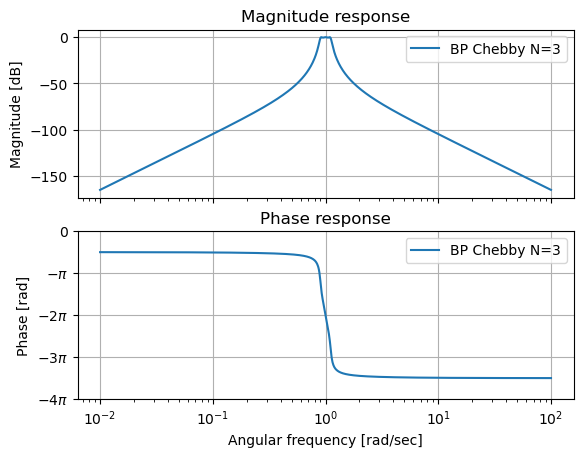

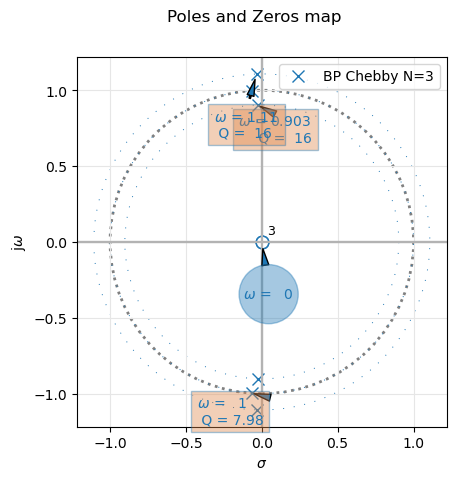

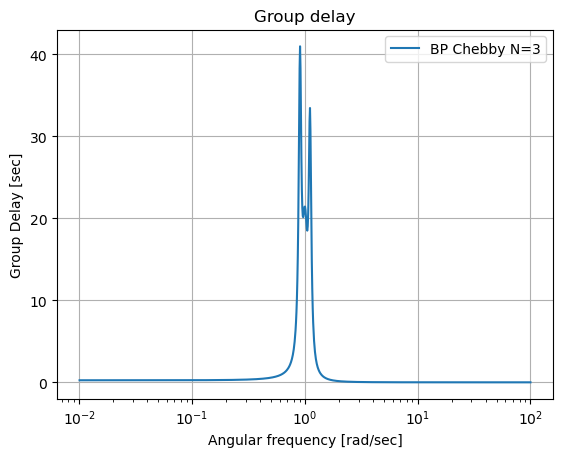

In [7]:
num = np.array(numerador)
den = np.array(denominador)
H1 = signal.TransferFunction( num, den )

analyze_sys(H1,"BP Chebby N=3",same_figs=False)


### Implementacion en sistemas de segundo orden separados

Para poder implementar el circuito es necesario obtener la transferencia en varios polinomios de primer o segundo orden, para ello calculamos las raices de la transferencia obtenida y con esos polos obtenemos las diferentes transferencias. Tambien calculamos la ganancia adicional que tiene que tener el circuito para poder llegar a una ganancia de 0db.


In [8]:
sos = signal.tf2sos(num, den, analog=True)

num1 = [sos[1][4], 0]
den1 = sos[1][3:]

num2 = [sos[0][4], 0]
den2 = sos[0][3:]

num3 = [sos[2][4], 0]
den3 = sos[2][3:]

k = (num[0]/(num1[0]*num2[0]*num3[0]))

print("Transferenica 1")
pretty_print_lti(num1, den1)
print("Transferenica 2")
pretty_print_lti(num2, den2)
print("Transferenica 3")
pretty_print_lti(num3, den3)
print(f"k = {k}")



Transferenica 1


<IPython.core.display.Math object>

Transferenica 2


<IPython.core.display.Math object>

Transferenica 3


<IPython.core.display.Math object>

k = 11.766044221671265


A continuacion se muestan las 3 transferencias analizadas:

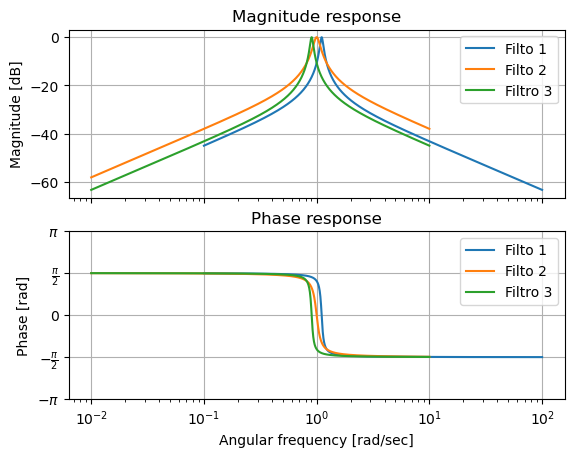

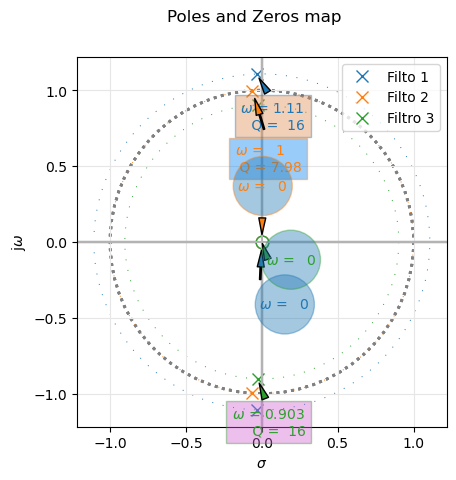

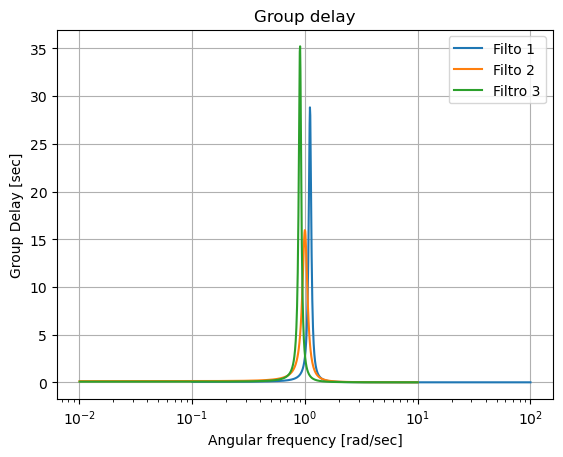

In [9]:
H2 = signal.TransferFunction( num1, den1 )
H3 = signal.TransferFunction( num2, den2 )
H4 = signal.TransferFunction( num3, den3 )
H = [H2,H3,H4]
analyze_sys(H,["Filto 1","Filto 2","Filtro 3"],same_figs=True)

A continuacion se muestran los valores obtenidos del filtro para cada uno de los paremetros calculados.

Transferencia en banda de paso:

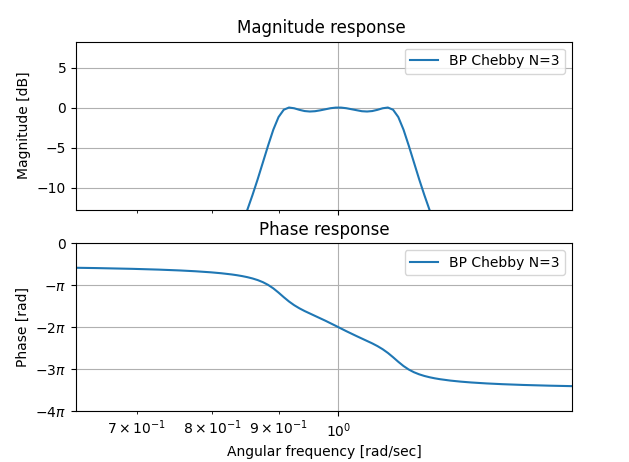

En esta imagen se observan las oscilaciones debido a que el filtro es de tipo Chebyshev

Se observa que la atenuacion maxima en esta banda es de 0.5db

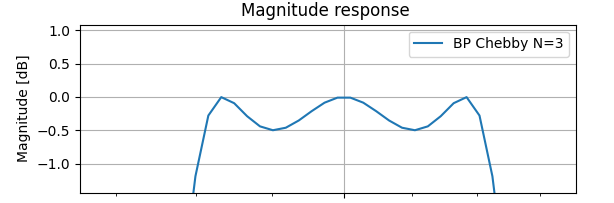

A continuacion se muestran las frecuencias de corte ($\omega_{p1}$ y $\omega_{p2}$).
Recordando que: $\omega_{p1}=0.904$ ; $\omega_{p2}=1.1049$ Y que la atenuacion maxima era de 0.5db

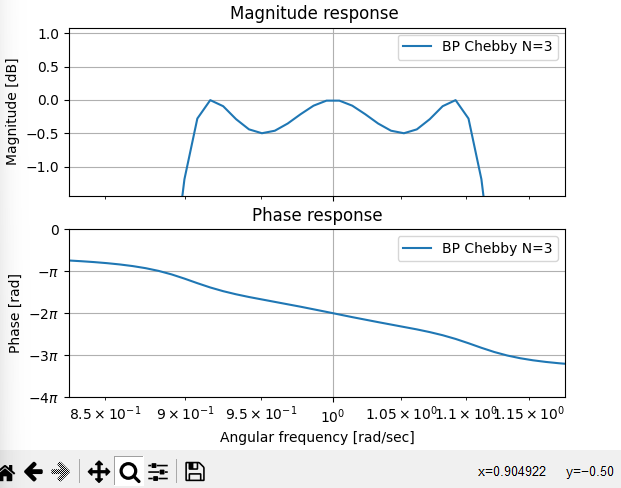

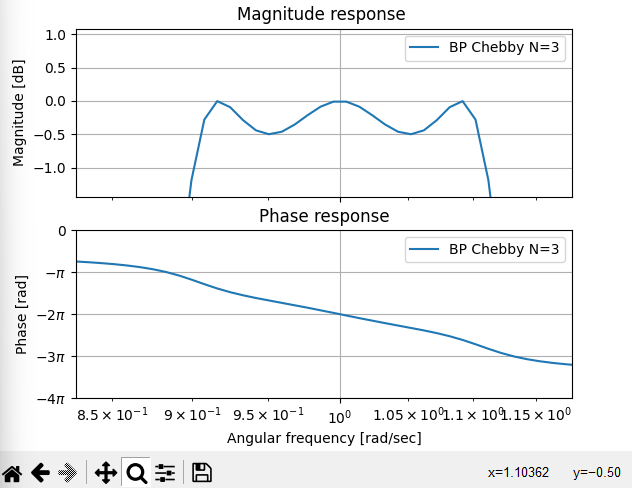

Ahora se analizan los punto de $\omega_{s1}$ y $\omega_{s2}$.
Recordando que: $\omega_{s1}=0.772$ ; $\omega_{s2}=1.636$ Y que la atenuacion minima era de -16dB y -24dB respectivamente.
NOTA: tener en cuenta que debido a que el orden que se tomo es N=3, la atenuacion en las bandas de stop será aun mayor, siendo este el filtro mas eficiente para cumplir con la plantilla.
Recordemos que:
 * alpha_min=26.86 para un n=3

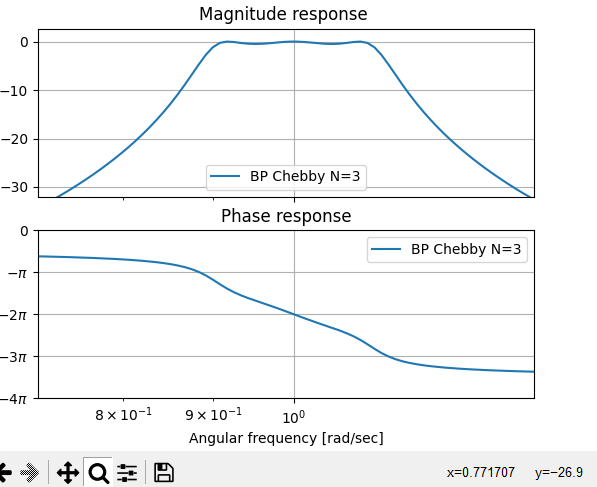

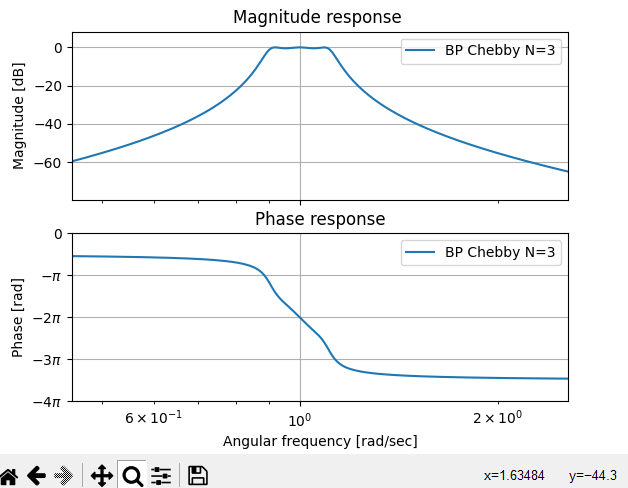

Al ser el filtro no simetrico vemos como la las atenuaciones para cada frecuencia especificada seran distintas. Sin embargo ambas cumplen con el reuquisito minimo del filtro


### Implementacion del filtro con componentes pasivos y seguidores

In [10]:
#Componentes normalizados del filtro

omega1 = np.sqrt(den1[2])
q1 = omega1/den1[1]

print(f"Seccion 1:  omega={omega1}  Q={q1})")
print(f"Seccion 1:  R=1  C={q1/omega1}  L={1/(q1*omega1)})")
print("")

omega2 = np.sqrt(den2[2])
q2 = omega2/den2[1]

print(f"Seccion 2:  omega={omega2}  Q={q2})")
print(f"Seccion 2:  R=1  C={q2/omega2}  L={1/(q2*omega2)})")
print("")

omega3 = np.sqrt(den3[2])
q3 = omega3/den3[1]

print(f"Seccion 3:  omega={omega3}  Q={q3})")
print(f"Seccion 3:  R=1  C={q3/omega3}  L={1/(q3*omega3)})")

print(f"K = {k}")


Seccion 1:  omega=1.1074509353143023  Q=16.046669259029144)
Seccion 1:  R=1  C=14.48973380881654  L=0.05627177368886195)

Seccion 2:  omega=0.9999999999999853  Q=7.9817279715413685)
Seccion 2:  R=1  C=7.981727971541486  L=0.12528615402147095)

Seccion 3:  omega=0.9029745410041161  Q=16.046669259031194)
Seccion 3:  R=1  C=17.770898879593158  L=0.06901438033260439)
K = 11.766044221671265


<h2>Simulación en LTspice</h2>

Durante la realización de la simulacion con valores de componentes nomralizados, nos encontramos con una discrepancia chica con la teoria. Luego de investigar este problema, llegamos a la conclusión de que el problema estaba en simular con valores normalizados. Cuando se simula de esta forma, los componentes pasivos tienen resistencias y reactancias en el orden de los $1\Omega$, creemos que esto puede causar conflicto con las resistencias internas de salida del modelo de amplificador operacional que usamos. Este efecto era lo suficientemente grande como para disminuir la ganancia en la banda de paso por 1dB y deformar el modulo de la señal significativamente. Debido a esto decidimos realizar la simulación con una norma de impedancia de $1k\Omega$, de esta forma se obtienen resultados con menos interferencia de comportamientos no ideales.

Como el filtro objetivo requiere una constante de ganancia $K=11.7$, fue necesario convertir uno de los seguidores para que tenga esta ganancia.

A continuación se muestra el circuito diseñado en LTSpice.
<div>
   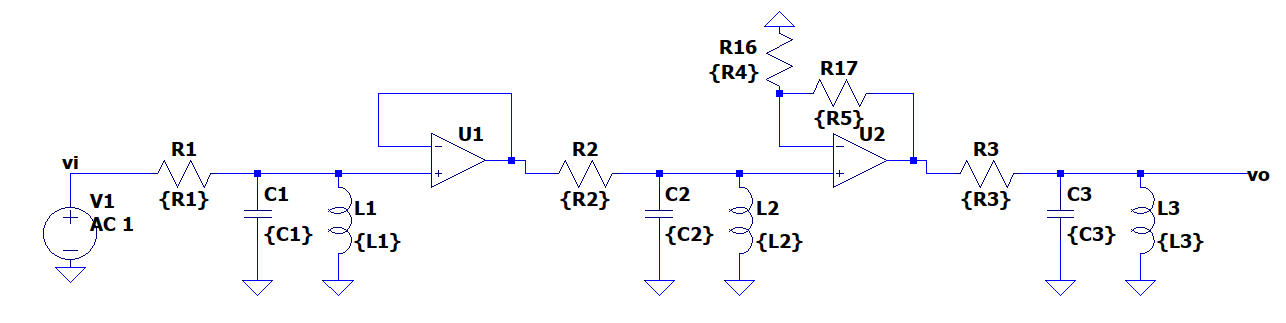
</div>
    
<div>
   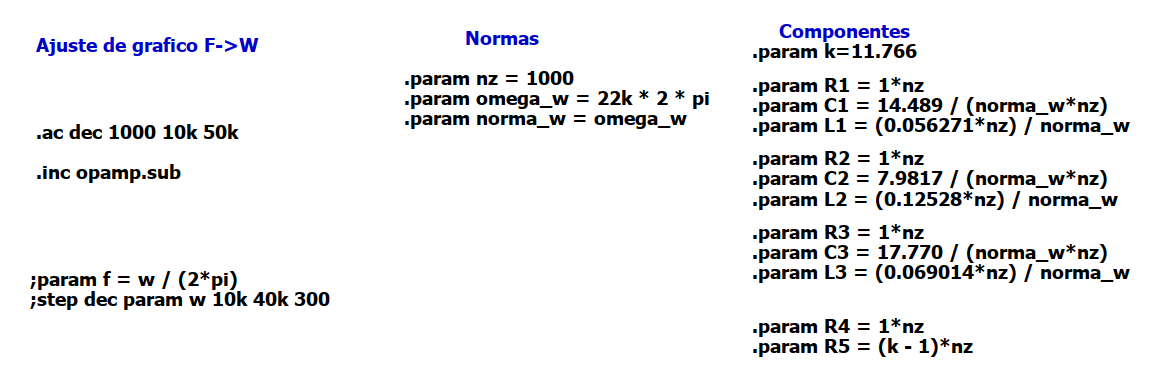
</div>

La respuesta en frecuencia del filtro obtenida es la siguiente:

<div>
   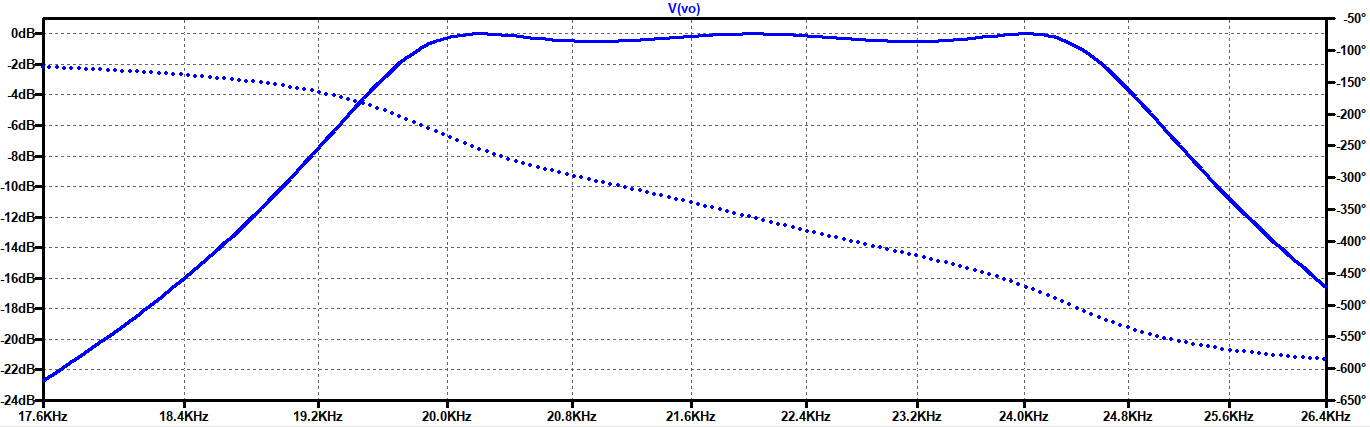
</div>

Si analizamos las frecuencias de paso y de corte utilizando el directivo **.meas** obtenemos:

|   Freq      |Ganancia|
|-------------|--------|
|$\omega_{p1}$|-0.52dB |
|$\omega_{p2}$|-0.52dB |
|$\omega_{s1}$|-26.8dB |
|$\omega_{s2}$|-26.8dB |



Como se pudo observar en las simulaciones en LT-Spice se pudo cumplir con las condiciones de la plantilla propuesta.
Debido a que la implementacion fue hecha con un filtro de orden 3, se obtuvo un filtro con mejores caracteristicas de las pedidas como puede ser la atenuacion minima en la banda de parada.


### Activacion del circuito utilizando un GIC pasabanda.

La red propuesta en la consigna consiste de un GIC pasabanda, identico al que se describe en el capitulo 4.5 del libro _Design of Analog Filter_ de Rolf Schaumann. A continuación se muestra la red como se encuentra en el libro.

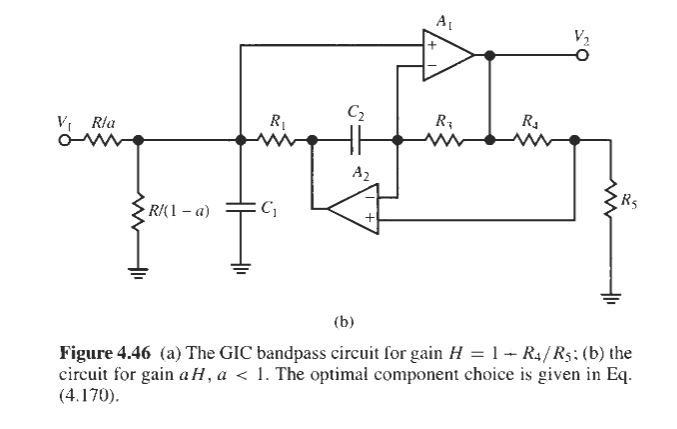

Esta red para $R_1 = R_3 = R_4 = R_5$, $C = C_1 = C_2$ y $0<a<1$ tiene la siguiente transferencia pasabanda con los siguientes parametros:

$$T(s) = K\dfrac{\dfrac{\omega_0}{Q} s}{s^2 + \dfrac{\omega_0}{Q} s + \omega_0^2}$$

$$\omega_0 = \dfrac{1}{C R_1}$$
$$Q = \dfrac{R}{R_1}$$
$$K = 2a$$

Utilizando los parametros $\omega_0$ y $Q$ de cada etapa como se encontro anteriormente, se puede diseñar el filtro objetivo facilemente.
Como la ganancia total del filtro es aproximadamente $11.7$, esta no se puede lograr con las 3 etapas de GIC, ya que cada una como maximo puede tener una constante de ganancia de $2$, esto hace que entre las tres tengan una ganancia de como mucho $8$ veces, si se toma $a=1$ para todas las etapas. Para llegar a $11.7$ es necesario agregar una etapa adicional con una amplificacion de $11.7/8 = 1.47$ veces.

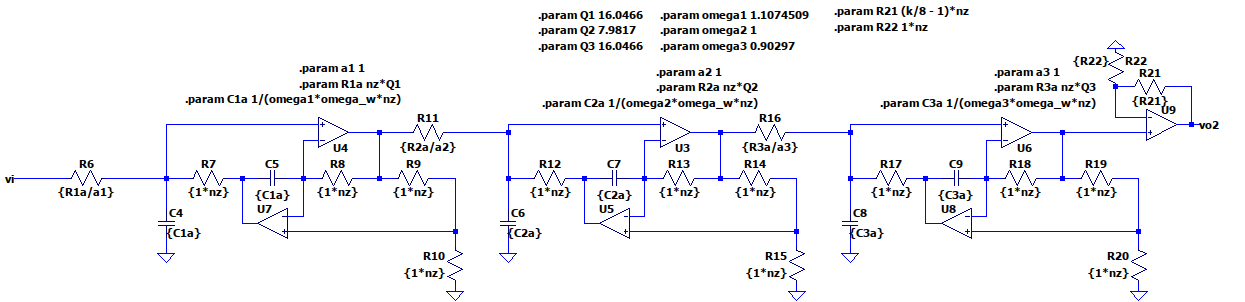

### Resultados de la simulacion del circuito activado

A continuacion se muestra el resultado de la simulación del filtro activado con un GICs.
En verde esta graficada la respuesta del filtro original, y en azul la respuesta del filtro activado.

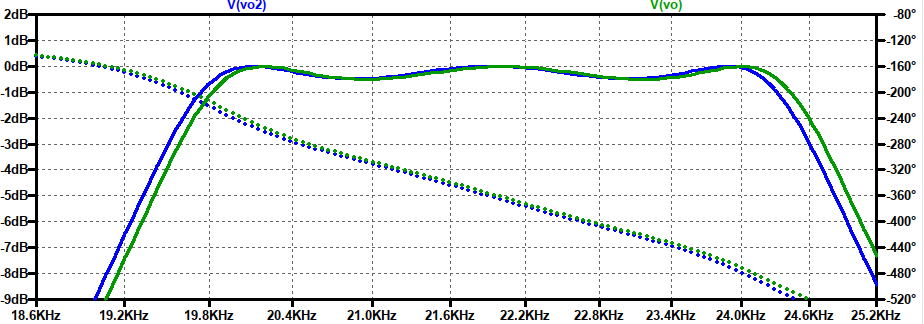

Se puede obserbar una diferencia chica entre estas dos respuestas. Esto se debe a comportamientos no ideales del modelo de amplificador operacional utilizado. Modificando el parametro del modelo "GBW" de 10MHz a 10GHz, resuelve este problema. A continuación se muestra la simulacion con el parametro GBW corregido.

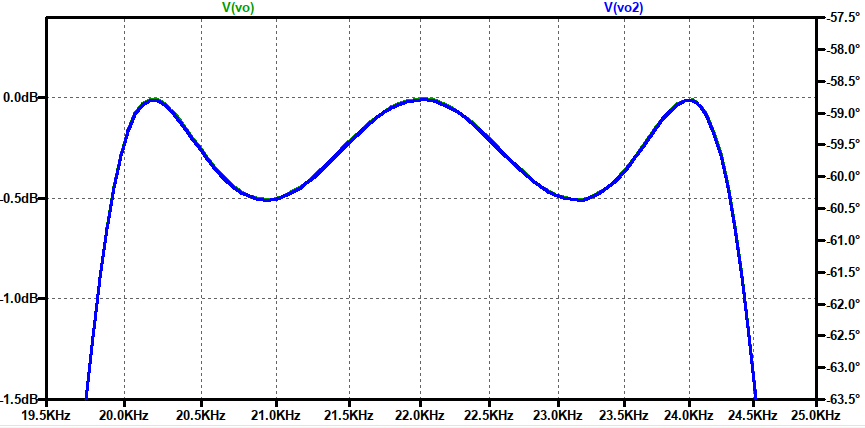

## Conclusiones

La sintesis de este filtro nos sirvió para ejercitar los conceptos de transformación en frecuencia, en particular para el caso mas complejo de transformacion, de pasa bajos hacia pasa banda. A pesar de no habernos topado con ninguna dificultad mayor en los calculos, nos encontramos con comportamientos inesperados en la simulación, en particular la deformación de la respuesta para valores normalizados y la discrepancia ligera entre la versión con inductores y la versión con GICs. 

Estos problemas nos sirvieron para darnos cuenta de que los el modelo que comunmente utilizamos para los amplificadores operacionales en LTspice, no son ideales por defecto, y si de ser necesario aproximarse mas a un modelo ideal, debemos cambiar los parametros. 

Aprender sobre la red GIC pasa banda también nos fue de gran utilidad como una herramienta nueva para diseñar filtros pasabanda de forma sistemática.

Algunas de las conclusiones discutidas son las siguientes:

* Se observó que el filtro pasa banda presenta una atenuación intrínseca, lo que significa que en una implementación pasiva pura no es posible lograr una banda de paso con ganancia de 0 dB. Sin embargo, se verificó que las etapas de segundo orden individualmente no presentan atenuación por sí mismas. Cada una de ellas tiende a tener una banda de paso con ganancia de 0 dB. La atenuación del filtro pasa banda se debe a la multiplicación de las transferencias de segundo orden, ya que cada una de ellas tiene una frecuencia central diferente y responde de manera distinta a cada frecuencia.

* Se llegó a la conclusión de que, aunque existe una atenuación en el filtro pasa banda, esta atenuación es constante en toda la banda de paso, lo cual hace que sea un problema menor. Para solucionarlo, simplemente se requiere agregar una etapa amplificadora para compensar la atenuación.

* Se planteó la posibilidad de resolver el problema de la atenuación al implementar en el circuito GIC o girador una ganancia mayor.Para ello se propuso modificar la relación de resistencias en una de las etapas, lo cual permitiría ahorrar un amplificador operacional. Esta modificación se muestra en el siguiente esquema.

    
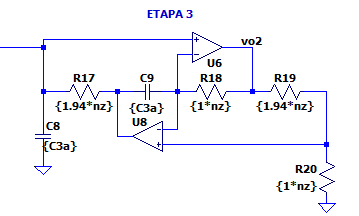

* Se realizó un cambio en el circuito mediante el aumento de la ganancia del operacional U6, el cual se configuró como un amplificador no inversor con una ganancia igual a (1 + R19/R20). Esta modificación tuvo como objetivo abordar la atenuación inherente del filtro pasa banda. Es importante destacar que al modificar una resistencia en el circuito del girador, también es necesario ajustar otra resistencia para contrarrestar su efecto en la formación del inductor. Por lo tanto, el valor de R17 también se vio afectado debido a esta consideración.

Con esta modificación, se logró obtener la siguiente respuesta del filtro

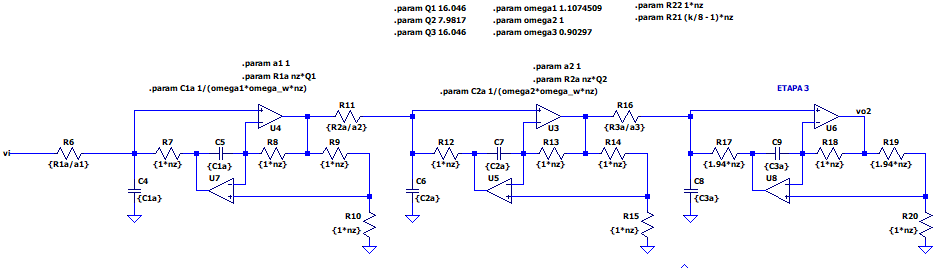

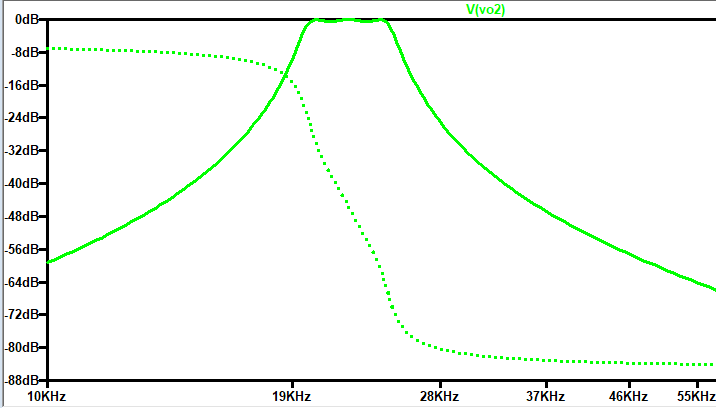

* Podemos afirmar con confianza que salir por uno de los operacionales en el GIC es una opción más recomendable y tiene ventajas significativas en comparación con salir por el mismo punto por el que entramos al circuito. Al salir por uno de los operacionales, podemos obtener una ganancia de tensión adicional, lo cual puede ser beneficioso en ciertas aplicaciones donde se requiere amplificación.
Además, al salir por un operacional en el GIC, evitamos cargar directamente al circuito de etapas posteriores. Esto es especialmente importante si las etapas posteriores tienen una alta impedancia de entrada, ya que no deseamos introducir una carga significativa que pueda afectar el rendimiento general del sistema.

* Destacamos el uso de la simulación numérica como una herramienta valiosa para resolver y analizar filtros. En el aprendizaje de diseño de filtros, la simulación numérica ofrece una forma práctica y efectiva de comprender el comportamiento de los circuitos, probar diferentes configuraciones y optimizar el rendimiento del filtro.
La simulación numérica nos permite obtener respuestas en frecuencia, diagramas de Bode, análisis de estabilidad y otras características del filtro de manera rápida y precisa. Esto nos ayuda a comprender cómo se comportará el filtro en diferentes condiciones y a realizar ajustes para lograr los resultados deseados.